In [157]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

In [158]:
import pandas as pd
import numpy as np
from pathlib import Path
import shutil
import time
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
import yaml
from types import SimpleNamespace

from train import create_image_transforms
from modules import ResNetRegressionNet
from datasets import FlowPhotoDataset
from losses import MSELoss
from utils import load_pairs_from_csv, fit, validate, MetricLogger

In [164]:
root_dir = '/home/jeff/data/fpe/experiments/20241209-WB0-aux'
data_dir = Path(root_dir) / 'data'

In [165]:
# load args from config/default.yml
with open('../configs/default.yml', 'r') as f:
    args = yaml.safe_load(f)
args = SimpleNamespace(**args)
args.images_dir = '/home/jeff/data/fpe/images'
args.gpu = 0
args

namespace(epochs=30,
          lr=0.001,
          unfreeze_after=2,
          batch_size=64,
          eval_batch_size=None,
          momentum=0.9,
          scheduler_patience=1,
          scheduler_factor=0.5,
          resnet_size=18,
          truncate=2,
          dropout_rate=0.0,
          use_batch_norm=False,
          weight_init='none',
          input_size=480,
          crop_ratio=0.8,
          transform_grayscale=False,
          transform_normalize=True,
          transform_normalize_n=1000,
          transform_random_crop=True,
          transform_flip=False,
          transform_rotate=True,
          transform_rotate_degrees=10,
          transform_color_jitter=False,
          transform_color_jitter_brightness=0.2,
          transform_color_jitter_contrast=0.2,
          transform_color_jitter_saturation=0.2,
          transform_color_jitter_hue=0.1,
          transform_perspective=False,
          transform_perspective_distortion=0.2,
          transform_auto_cont

## Dataset

In [172]:
images_df = pd.read_csv(Path(data_dir) / 'images-split.csv')
images_df.head()

,split,image_id,timestamp,filename,url,value,date,daymet_1d_dayl,daymet_1d_prcp,daymet_1d_srad,...,daymet_30d_srad_z,daymet_30d_swe_z,daymet_30d_tmax_z,daymet_30d_tmin_z,daymet_30d_tavg_z,daymet_30d_vp_z,jday_z,dhour_z,obs_z,rand_z
0,train,1395116,2022-12-11T20:45:01Z,imagesets/e2a3b2b6-d391-481a-9814-dc61cf83a990...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,1.041393,2022-12-11,32176.84,10.19,55.57,...,0.067646,0.076576,0.267308,0.336293,0.302538,0.153402,0.945055,0.729207,0.486206,0.424416
1,train,2083970,2023-04-13T13:00:00Z,imagesets/e33129ab-64df-48f7-9380-1be3258b577f...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,1.220108,2023-04-13,47044.64,0.00,482.76,...,0.875086,0.008082,0.421171,0.367216,0.396876,0.170685,0.280220,0.166671,0.526842,0.204199
2,train,1647520,2023-01-25T20:15:00Z,imagesets/265292ae-007e-4a94-a86c-e01028d85c1f...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,1.466868,2023-01-25,34259.98,36.06,160.78,...,0.064178,0.186383,0.165141,0.319461,0.241741,0.138325,0.065934,0.687516,0.582950,0.168821
3,train,624015,2022-05-22T14:42:37Z,imagesets/33c0736b-f5fb-4da6-91b0-83a72c285382...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,0.824776,2022-05-22,52705.60,7.45,359.83,...,0.805446,0.000000,0.648967,0.636904,0.648051,0.431605,0.387363,0.309197,0.436951,0.671610
4,train,802594,2022-07-24T19:09:06Z,imagesets/a7918a28-258e-40a7-bf79-8aa1895d4c65...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,-0.327902,2022-07-24,52431.34,1.67,418.20,...,0.854803,0.000000,0.953107,0.905435,0.937817,0.787435,0.560440,0.679321,0.174856,0.176717


In [174]:
train_images_df = images_df[images_df['split'] == 'train']
val_images_df = images_df[images_df['split'] == 'val']
test_in_images_df = images_df[images_df['split'] == 'test-in']
test_out_images_df = images_df[images_df['split'] == 'test-out']
print(len(train_images_df), len(val_images_df), len(test_in_images_df), len(test_out_images_df))

1000 200 1603 995


## Experiments

### Run 01: Regression Model Using Only Images

Regression model using only images.

In [106]:

run_dir = Path(root_dir) / 'runs' / 'run-01'
run_model_dir = Path(run_dir) / 'model'
run_output_dir = Path(run_dir) / 'output'
run_checkpoint_dir = Path(run_dir) / 'checkpoints'

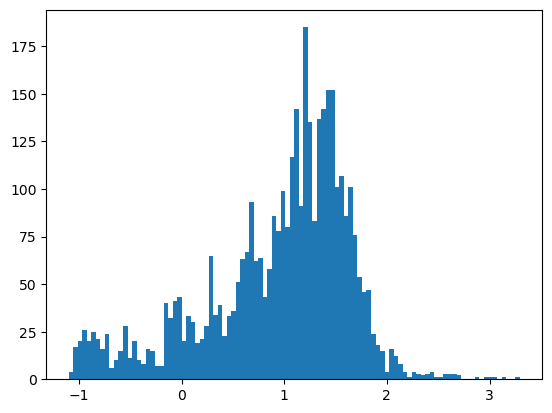

In [176]:
# plot images_df['value']
import matplotlib.pyplot as plt
plt.hist(images_df['value'], bins=100)
plt.show()

In [177]:
train_ds = FlowPhotoDataset(train_images_df, args.images_dir)

In [178]:
img_mean, img_std = train_ds.compute_mean_std(args.transform_normalize_n)
print("Image statistics - Mean: %s, Std: %s", img_mean, img_std)

100%|██████████| 1000/1000 [00:35<00:00, 28.23it/s]

Image statistics - Mean: %s, Std: %s [0.42330913 0.42318689 0.38943786] [0.29321355 0.29218129 0.28678856]


In [179]:
image = train_ds.get_image(0)
aspect = image.shape[2] / image.shape[1]
image_shape = image.shape
resize_shape = [args.input_size, int(args.input_size * aspect)]
input_shape = [
    int(args.input_size * args.crop_ratio), 
    int(args.input_size * args.crop_ratio * aspect)
]
print(input_shape, resize_shape)

[384, 512] [480, 640]


In [180]:
transforms = create_image_transforms(
  resize_shape=resize_shape,
  input_shape=input_shape,
  transform_grayscale=args.transform_grayscale,
  transform_random_crop=args.transform_random_crop,
  transform_flip=args.transform_flip,
  transform_rotate=args.transform_rotate,
  transform_rotate_degrees=args.transform_rotate_degrees,
  transform_color_jitter=args.transform_color_jitter,
  transform_color_jitter_brightness=args.transform_color_jitter_brightness,
  transform_color_jitter_contrast=args.transform_color_jitter_contrast,
  transform_color_jitter_saturation=args.transform_color_jitter_saturation,
  transform_color_jitter_hue=args.transform_color_jitter_hue,
  transform_normalize=args.transform_normalize,
  channel_mean=img_mean,
  channel_stdev=img_std,
  transform_perspective=args.transform_perspective,
  transform_perspective_distortion=args.transform_perspective_distortion,
  transform_auto_contrast=args.transform_auto_contrast,
  transform_equalize=args.transform_equalize,
  transform_gamma=args.transform_gamma,
  transform_gamma_min=args.transform_gamma_min,
  transform_gamma_max=args.transform_gamma_max,
  transform_gaussian_blur=args.transform_gaussian_blur,
  transform_blur_kernel=args.transform_blur_kernel,
)

In [182]:
train_ds.transform = transforms["train"]
val_ds = FlowPhotoDataset(
    val_images_df,
    args.images_dir,
    transform=transforms["eval"]
)

In [183]:
train_dl = DataLoader(
    train_ds,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
)
eval_batch_size = args.eval_batch_size or args.batch_size
val_dl = DataLoader(
    val_ds,
    batch_size=eval_batch_size,
    shuffle=False,
    num_workers=args.num_workers
)

In [184]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [185]:
def fit(model, criterion, optimizer, train_dl, device, epoch_num=None, verbose=False):
    """Train model for one epoch.

    Args:
        model (torch.nn.Module): network to train
        criterion (torch.nn.Module): loss function(s) used to train network weights
        optimizer (torch.optim.Optimizer): algorithm used to optimize network weights
        train_dl (torch.utils.DataLoader): data loader for training set
    Returns:
        batch_loss_logger.avg (float): average criterion loss per batch during training
    """
    model.train()  # ensure model is in train mode
    # train_dl.dataset.train()  # ensure train transforms are applied
    batch_loss_logger = MetricLogger()
    batch_time_logger = MetricLogger()

    for bidx, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        batch_starttime = time.time()

        inputs, labels = batch
        if next(model.parameters()).is_cuda:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        batch_loss_logger.update(loss.item())
        loss.backward()
        optimizer.step()

        batch_endtime = time.time()
        batch_time_logger.update(batch_endtime - batch_starttime)
    return batch_loss_logger.avg

def validate(model, criterions, dl, device):
    model.eval()
    criterion_loggers = [MetricLogger() for i in range(len(criterions))]
    with torch.no_grad():  # ensure no gradients are computed
        for bidx, batch in tqdm(enumerate(dl), total=len(dl)):
            model_outputs = {}
            for i, c in enumerate(criterions):
                # inputs ->[model]-> outputs ->[criterion]-> value
                if "outputs" not in model_outputs.keys():
                    # store model outputs from forward pass in case another criterion needs the same
                    inputs, labels = batch
                    if next(model.parameters()).is_cuda:
                        inputs = inputs.float().to(device)
                        labels = labels.float().to(device)
                    outputs = model(inputs)
                    model_outputs["outputs"] = outputs
                else:
                    # load previously computed model outputs from forward pass
                    outputs = model_outputs["outputs"]
                cval = c(outputs, labels)
                criterion_loggers[i].update(cval.item())
    return [cl.avg for cl in criterion_loggers]

from train import save_checkpoint

In [186]:
# set up model
model = ResNetRegressionNet(
    input_shape=(3, input_shape[0], input_shape[1]),
    transforms=transforms,
    resnet_size=args.resnet_size,
    truncate=args.truncate,
    dropout_rate=args.dropout_rate,
    use_batch_norm=args.use_batch_norm
)

# Freeze resnet backbone initially
for p in list(model.children())[0].parameters():
    p.requires_grad = False

model = nn.DataParallel(model, device_ids=[args.gpu])
model = model.to(device)
print(model.module.get_model_summary())

optimizer = SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
criterion = MSELoss()
scheduler = ReduceLROnPlateau(
    optimizer, "min", 
    patience=args.scheduler_patience, 
    factor=args.scheduler_factor
)

{'total_parameters': 11324353, 'trainable_parameters': 147841, 'frozen_parameters': 11176512, 'resnet_size': 'Sequential', 'fc_layers': [256, 64, 1], 'input_shape': (3, 384, 512)}


In [187]:
metrics = {"epoch": [], "train_loss": [], "val_loss": []}
min_val_loss = float('inf')
best_epoch = None
total_train_time = 0
epoch_times = []
patience_counter = 0
start_epoch = 0
args.epochs = 30
for epoch in range(start_epoch, args.epochs):
    epoch_start_time = time.time()
    print(f"Epoch {epoch + 1}/{args.epochs}")

    # Train
    start_time = time.time()
    train_loss = fit(model, criterion, optimizer, train_dl, device, epoch)
    train_time = time.time() - start_time
    print(f"Training - Loss: {train_loss:.4f} ({train_time:.1f} s)")
    metrics["train_loss"].append(train_loss)
    metrics["epoch"].append(epoch)

    # Validate
    start_time = time.time()
    val_loss = validate(model, [criterion], val_dl, device)[0]
    val_time = time.time() - start_time
    print(f"Validation - Loss: {val_loss:.4f} ({val_time:.1f} s)")
    metrics["val_loss"].append(val_loss)

    # Timing
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    total_train_time += epoch_time

    # Learning rate update
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if old_lr != new_lr:
      print(f"Learning rate adjusted: {old_lr:.6f} -> {new_lr:.6f}")

    # Save checkpoint
    checkpoint_path = Path(checkpoint_dir) / f"epoch_{epoch:02d}.pth"
    save_checkpoint(
        checkpoint_path, epoch, model, optimizer, train_loss,
        transforms,
        {
            "aspect": aspect,
            "input_shape": input_shape,
            "img_sample_mean": img_mean,
            "img_sample_std": img_std,
            "args": args.__dict__
        }
    )

    # Check for improvement
    if val_loss < (min_val_loss - args.early_stopping_min_delta):
        improvement = min_val_loss - val_loss
        if epoch == 0:
            print("Initial checkpoint - Saving")
        else:
            print(f"Model validation loss improved by {improvement:.4f} - Saving checkpoint as best model")
        best_model_path = Path(model_dir) / "model.pth"
        shutil.copy(checkpoint_path, best_model_path)
        min_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs")
        
        if patience_counter >= args.early_stopping_patience:
            print(f"Early stopping triggered - No improvement for {args.early_stopping_patience} epochs")
            break

    # Save metrics
    pd.DataFrame(metrics).to_csv(Path(output_dir) / "metrics.csv", index=False)

    # Backbone unfreezing
    if (epoch + 1) == args.unfreeze_after:
        print(f"Unfreezing CNN backbone at epoch {epoch + 1}")
        for p in list(model.children())[0].parameters():
            p.requires_grad = True

    # Checkpoint management based on save frequency and keep limit
    if epoch % args.save_frequency == 0:
        checkpoint_path = Path(checkpoint_dir) / f"epoch_{epoch:02d}.pth"
        save_checkpoint(
            checkpoint_path, epoch, model, optimizer, train_loss,
            transforms,
            {
                "aspect": aspect,
                "input_shape": input_shape,
                "img_sample_mean": img_mean,
                "img_sample_std": img_std,
                "args": args.__dict__
            }
        )

        # Remove old checkpoints if needed
        if args.keep_n_checkpoints > 0:
            checkpoints = sorted(Path(checkpoint_dir).glob("epoch_*.pth"))
            if len(checkpoints) > args.keep_n_checkpoints:
                for checkpoint in checkpoints[:-args.keep_n_checkpoints]:
                    checkpoint.unlink()

    # Update completion message
    final_epoch = epoch + 1
    if patience_counter >= args.early_stopping_patience:
        print(f"Training stopped early at epoch {final_epoch}/{args.epochs}")
    else:
        print(f"Training completed all {args.epochs} epochs")

    print(f"Total training time: {total_train_time:.1f} s")
    print(f"Average epoch time: {sum(epoch_times) / len(epoch_times):.1f} s")
metrics


Epoch 1/30


  0%|          | 0/16 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 0 has a total capacity of 15.69 GiB of which 131.75 MiB is free. Including non-PyTorch memory, this process has 15.54 GiB memory in use. Of the allocated memory 14.37 GiB is allocated by PyTorch, and 904.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

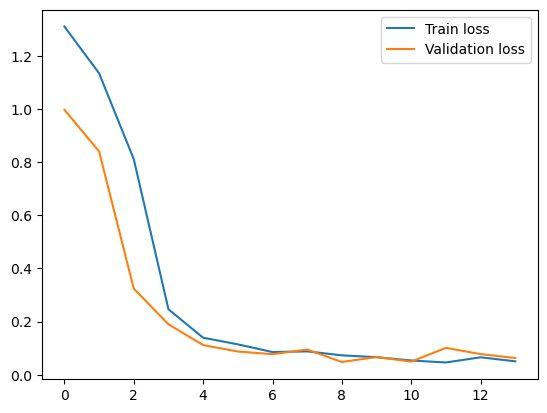

In [152]:
# plot train/val loss
plt.plot(metrics['epoch'], metrics['train_loss'], label='Train loss')
plt.plot(metrics['epoch'], metrics['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [150]:
def predict_batch(
    model: nn.Module,
    dataset: FlowPhotoDataset,
    device: torch.device
) -> np.ndarray:
    """Generate predictions for a dataset.
    
    Args:
        model: Loaded model
        dataset: Dataset to predict
        device: Target device
        
    Returns:
        Array of predictions
    """
    predictions = []
    
    with torch.no_grad():
        for image, _ in tqdm(dataset, desc="Generating predictions"):
            # Move image to device and get prediction
            image = image.to(device)
            transformed = model.module.transforms['eval'](image)
            output = model.module.forward(transformed.unsqueeze(0))
            score = output.detach().cpu().numpy().item()
            predictions.append(score)
            
    return np.array(predictions)


In [151]:
# load images with split=test-out
test_df = images_df[images_df['split'] == 'test-out'].copy()
test_ds = FlowPhotoDataset(test_df, args.images_dir)

scores = predict_batch(model, test_ds, device)
test_df['score'] = scores
test_df.to_csv(Path(output_dir) / "test-images.csv", index=False)

Generating predictions:   0%|          | 0/16518 [00:00<?, ?it/s]

Generating predictions: 100%|██████████| 16518/16518 [05:27<00:00, 50.36it/s]


In [153]:
from scipy import stats
tau = stats.kendalltau(scores, test_df['value'])[0]
rho = stats.spearmanr(scores, test_df['value'])[0]
rmse = np.sqrt(np.mean((scores - test_df['value'])**2))
print(f"Kendall tau: {tau:.4f}, Spearman rho: {rho:.4f}, RMSE: {rmse:.4f}")

Kendall tau: 0.8531, Spearman rho: 0.9670, RMSE: 0.2329


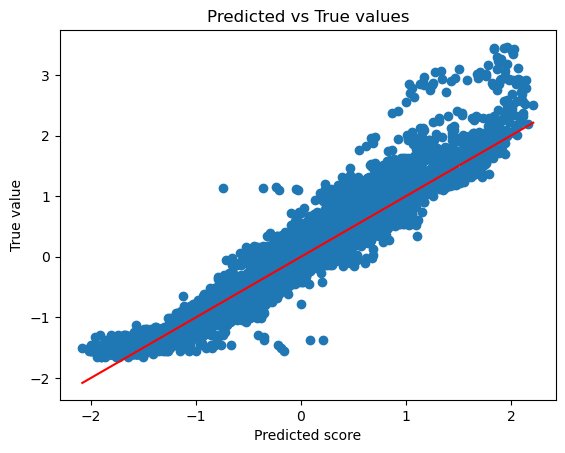

In [155]:
# plot scores vs values
plt.scatter(scores, test_df['value'])
plt.plot([scores.min(), scores.max()], [scores.min(), scores.max()], color='red')
plt.xlabel('Predicted score')
plt.ylabel('True value')
plt.title('Predicted vs True values')
plt.show()


## Experiment 2: Regression model using auxiliary data.